In [1]:
import numpy as np
from numpy import matlib as ml
import pandas as pd
import os
import warnings
import librosa
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from random import shuffle
import scipy.stats as st

from pynwb import NWBHDF5IO

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec

import pdb
warnings.filterwarnings('ignore')

In [2]:
# ----- SET UP COLORS -----
acols = [[0.627451,   0.57254905, 0.37254903],
        [0.9607843,  0.7882353,  0.15294118],
        [0.34901962, 0.35686275, 0.49019608],
        [0.24705882, 0.30588236, 0.9607843 ]]

fcols = acols[0:2]
mcols = acols[2:]

fpal = sns.color_palette(fcols)
mpal = sns.color_palette(mcols)
apal = sns.color_palette(acols)

# set hue order
ho = ['WT','Het']

In [3]:
# ----- LOAD DATA -----
data = pd.read_csv('all_annotations.csv')

In [ ]:
# huddle duration distribution

assays = ['introduction','reunion','aggression','timedMating']
behavior = ['huddle']
GT = ['WT']
sex = ['M']

assayIdx = data.assay.isin(assays)
behaviorIdx = data.behavior.isin(behavior)
gtIdx = data.GT.isin(GT)
sexIdx = data.sex.isin(sex)



In [4]:
# ----- FIGURES -----
outp = os.path.join('figures','2024August')

In [5]:
# ----- DEFINE FUNCTIONS -----

def bin_and_cume(data,assayLen,t):
    '''Bin data in 0.1s bins and then rebin into bins of t sec length.'''
    bind = make_bins_from_DF(data,assayLen) # tabulate data in 0.1s bins
    usebins = make_arbitrary_bins(assayLen,t) # generate list of edges for larger bins
    # sum up positive bins from initial cut to rebin
    rebin = bind.groupby([bind.pair_tag,pd.cut(bind.bins,usebins,labels=usebins[1:])])['data'].sum().reset_index()
    rebin['data']=rebin.data/10
    gtlist = bind.groupby(['pair_tag'])['GT'].apply(lambda x: np.unique(x)[0]).reset_index()
    sexlist = bind.groupby(['pair_tag'])['sex'].apply(lambda x: np.unique(x)[0]).reset_index()
    numlist = bind.groupby(['pair_tag'])['pair_number'].apply(lambda x: np.unique(x)[0]).reset_index()
    metatab = pd.merge(gtlist, sexlist, on='pair_tag', how='outer')
    metatab = pd.merge(metatab,numlist,on='pair_tag',how='outer')
    binmeta = pd.merge(rebin,metatab,on='pair_tag',how='outer')
    binmeta['cumes'] = binmeta.groupby(['pair_tag']).data.cumsum()
    binmeta['totals'] = binmeta.groupby(['pair_tag']).data.transform('sum')
    binmeta['cumes_frac'] = binmeta.cumes/binmeta.totals
    return binmeta

def make_arbitrary_bins(assaylen,stepsize):
    nrsteps = int((assaylen)/stepsize)
    bins = np.linspace(0, assaylen, num=nrsteps+1)
    return bins

def make_bins_from_DF(df,assaylen):

    allpairs = np.unique(df.pair_tag)
    
    stepsize = 0.1
    nrsteps = int((assaylen)/stepsize)
    bins = np.linspace(0, assaylen-stepsize, num=nrsteps)
    nrbins = len(bins)

    for j,pair in enumerate(allpairs):
        thisdf = df[df.pair_tag==pair]
        gt = np.unique(thisdf.GT)[0]
        sex = np.unique(thisdf.sex)[0]
        try:
            pn = np.unique(thisdf.pair_num)[0]
        except:
            pn = np.unique(thisdf.pair)[0]
        thisdf['starts_idx'] = np.round(thisdf.start_time,decimals=1)*10
        thisdf['ends_idx'] = np.round(thisdf.stop_time,decimals=1)*10
        startsl = thisdf.starts_idx.to_list()
        endsl = thisdf.ends_idx.to_list()
        blankbins = np.zeros((len(bins,)))
        for i,start in enumerate(startsl):
            blankbins[int(start):int(endsl[i])] = 1
        GTs = [gt]*nrsteps
        sexes = [sex]*nrsteps
        PTs = [pair]*nrsteps
        pairnr = [pn]*nrsteps
        bindat = {'bins': bins, 'data': blankbins, 'sex':sexes,'GT':GTs,'pair_tag':PTs,'pair_number':pairnr}
        bindf = pd.DataFrame(data=bindat) 

        if j==0:
            collbins = bindf
        else:
            collbins = pd.concat([collbins,bindf])
  
    collbins['raw_cumes'] = collbins.groupby('pair_tag').data.cumsum()/10
    collbins['totals'] = collbins.groupby('pair_tag')['data'].transform('sum')/10
    collbins['cumes_behav_frac'] = collbins.raw_cumes/collbins.totals
        
    return collbins

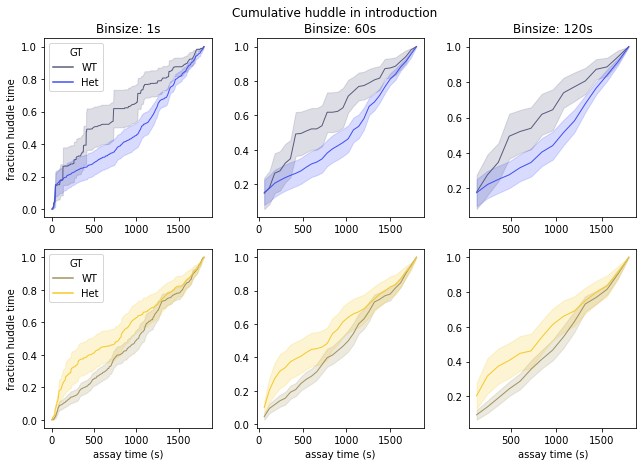

In [22]:
assay = 'introduction'
behavior = 'huddle'
bins = [1,60,120]
nrows = 2
ncols = len(bins)

trim = data[np.logical_and(data.behavior==behavior,data.assay==assay)]

f, ax = plt.subplots(nrows,ncols,figsize=(3*ncols, 3*nrows))
f.tight_layout()
f.suptitle(f'Cumulative {behavior} in {assay}', y=1.04)

for i,bsize in enumerate(bins):
    binned = bin_and_cume(introhuddles,1800,bsize)
    
    # plot males
    g = sns.lineplot(
        data=binned[binned.sex=='M'],
        x="bins", y="cumes_frac", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=mpal,hue_order=ho,
        ax = ax[0,i],
    )
    
    # plot females
    h = sns.lineplot(
        data=binned[binned.sex=='F'],
        x="bins", y="cumes_frac", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=fpal,hue_order=ho,
        ax = ax[1,i],
    )
    
    ax[1,i].set_xlabel('assay time (s)')
    ax[0,i].set_xlabel('')
    ax[0,i].set_title(f'Binsize: {bsize}s')
    
    if i>0:
        ax[0,i].set_ylabel('')
        ax[1,i].set_ylabel('')
        g.get_legend().remove()
        h.get_legend().remove()
    else:
        ax[0,i].set_ylabel(f'fraction {behavior} time')
        ax[1,i].set_ylabel(f'fraction {behavior} time')
        

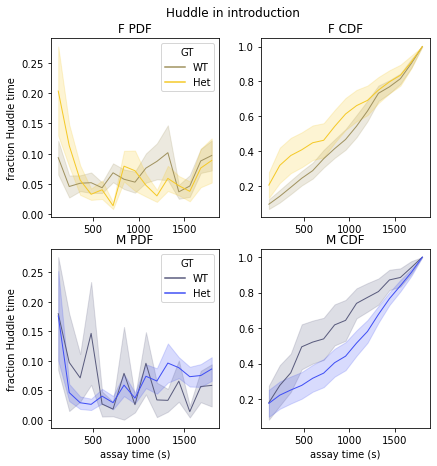

In [33]:
assay = 'introduction'
behavior = 'Huddle'
binsz = 60
nrows = 2
ncols = 2
sexes = ['F','M']

trim = data[np.logical_and(data.behavior==behavior,data.assay==assay)]

f, ax = plt.subplots(nrows,ncols,figsize=(3*ncols, 3*nrows))
f.tight_layout()
f.suptitle(f'{behavior} in {assay}', y=1.04)

binned = bin_and_cume(trim,1800,bsize)
binned['binned_fracs'] = binned.data/binned.totals

for i,sx in enumerate(sexes):
    
    if sx == 'F':
        upal = fpal
    else:
        upal = mpal
    
    # plot PDF
    g = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,1],
    )
    
    # plot CDF
    h = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="binned_fracs", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,0],
    )
    
    ax[1,i].set_xlabel('assay time (s)')
    ax[0,i].set_xlabel('')
    ax[i,0].set_title(f'{sx} PDF')
    ax[i,1].set_title(f'{sx} CDF')
    g.get_legend().remove()
    sns.despine(ax=ax[0,0],top=True,right=True)
    sns.despine(ax=ax[0,1],top=True,right=True)
    sns.despine(ax=ax[1,0],top=True,right=True)
    sns.despine(ax=ax[1,1],top=True,right=True)

    
    if i>0:
        ax[0,i].set_ylabel('')
        ax[1,i].set_ylabel('')
#         h.get_legend().remove()
    else:
        ax[0,i].set_ylabel(f'fraction {behavior} time')
        ax[1,i].set_ylabel(f'fraction {behavior} time')
        

In [6]:
def plot_PDF_ridge_plots(usedf,usegt,sx,assay,behavior,usecol):
    pairs = [x for x in np.unique(usedf.pair_tag)]

    gs = grid_spec.GridSpec(len(pairs),1)
    fig = plt.figure(figsize=(4,8))

    i = 0

    ax_objs = []
    for pair in pairs:
        x = np.array(usedf[usedf.pair_tag == pair].binned_fracs)
        x_d = np.array(usedf[usedf.pair_tag == pair].bins)

        # creating new axes object
        ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

        # plotting the distribution
        ax_objs[-1].plot(x_d, x,color="#ffffff",lw=2)
        ax_objs[-1].fill_between(x_d, x, alpha=0.5,color=usecol)


        # setting uniform x and y lims
        ax_objs[-1].set_xlim(0,1800)
        ax_objs[-1].set_ylim(0,1)

        # make background transparent
        rect = ax_objs[-1].patch
        rect.set_alpha(0)

        # remove borders, axis ticks, and labels
        ax_objs[-1].set_yticklabels([])
        ax_objs[-1].set_yticks([])


        if i == len(pairs)-1:
            ax_objs[-1].set_xlabel("assay time", fontsize=12)
        else:
            ax_objs[-1].set_xticklabels([])
            ax_objs[-1].set_xticks([])


        spines = ["top","right","left","bottom"]
        for s in spines:
            ax_objs[-1].spines[s].set_visible(False)

        i += 1

    gs.update(hspace=-0.75)

    fig.text(0.5,0.75,f"{usegt} {sx} {assay} {behavior}",fontsize=14,horizontalalignment='center')

    plt.tight_layout()
    plt.show()
    
    return fig

In [21]:
def plot_PDF_ridge_plots_quad(df,assay,behavior,acols,assaylen):
    
    sexes = ['F','M']
    GTs = ['WT','Het']
    npairs = np.max(df.pair_number)
    
    gs = grid_spec.GridSpec(npairs+1,4)
    fig = plt.figure(figsize=(12,8))
    
    colc = 0
    
    for sex in sexes:
        for GT in GTs:
            usedf = df[np.logical_and(df.sex==sex,df.GT==GT)]
            usecol = acols[colc]
    
    
            pairs = [x for x in np.unique(usedf.pair_tag)]

            i = 0

            ax_objs = []
            for pair in pairs:
                x = np.array(usedf[usedf.pair_tag == pair].binned_fracs)
                x_d = np.array(usedf[usedf.pair_tag == pair].bins)

                # creating new axes object
                try:
                    ax_objs.append(fig.add_subplot(gs[npairs-i:npairs-i+1, colc:colc+1]))
                except:
                    pdb.set_trace()


                # plotting the distribution
                ax_objs[-1].plot(x_d, x,color="#ffffff",lw=2)
                ax_objs[-1].fill_between(x_d, x, alpha=0.5,color=usecol)


                # setting uniform x and y lims
                ax_objs[-1].set_xlim(0,assaylen)
                ax_objs[-1].set_ylim(0,1)

                # make background transparent
                rect = ax_objs[-1].patch
                rect.set_alpha(0)
                
                # set the z order?
                ax_objs[-1].zorder=npairs-i

                # remove borders, axis ticks, and labels
                ax_objs[-1].set_yticklabels([])
                ax_objs[-1].set_yticks([])


                if i == 0:
                    ax_objs[-1].set_xlabel("assay time", fontsize=12)
                else:
                    ax_objs[-1].set_xticklabels([])
                    ax_objs[-1].set_xticks([])


                spines = ["top","right","left","bottom"]
                for s in spines:
                    ax_objs[-1].spines[s].set_visible(False)

                i += 1
            colc+=1

    gs.update(hspace=-0.75)

    fig.text(0.5,0.75,f"{behavior} in {assay}",fontsize=14,horizontalalignment='center')

    plt.tight_layout()
    plt.show()
    
    return fig

In [35]:
sexfilt.head()

,pair_tag,bins,data,GT,sex,pair_number,cumes,totals,cumes_frac,binned_fracs
0,Pair1,60.0,3.3,Het,F,0,3.3,83.2,0.039663,0.039663
1,Pair1,120.0,0.0,Het,F,0,3.3,83.2,0.039663,0.000000
2,Pair1,180.0,0.0,Het,F,0,3.3,83.2,0.039663,0.000000
3,Pair1,240.0,0.2,Het,F,0,3.5,83.2,0.042067,0.002404
4,Pair1,300.0,0.5,Het,F,0,4.0,83.2,0.048077,0.006010


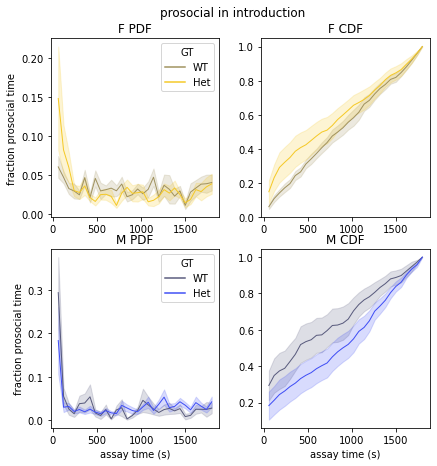

In [14]:
# ----- INTRO PROSOCIAL -----
prosoc = ['Huddle','Sniff','Investigate']
assay = 'introduction'
bsize = 60
sexes = ['F','M']

behavior = 'prosocial'

ncols = 2
nrows = len(sexes)

behaviorIdx = data.behavior.isin(prosoc)
trim = data[np.logical_and(behaviorIdx,data.assay==assay)]

f, ax = plt.subplots(nrows,ncols,figsize=(3*ncols, 3*nrows))
f.tight_layout()
f.suptitle(f'{behavior} in {assay}', y=1.04)

binned = bin_and_cume(trim,1800,bsize)
binned['binned_fracs'] = binned.data/binned.totals

for i,sx in enumerate(sexes):
    
    if sx == 'F':
        upal = fpal
    else:
        upal = mpal
    
    # plot PDF
    g = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,1],
    )
    
    # plot CDF
    h = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="binned_fracs", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,0],
    )
    
    ax[1,i].set_xlabel('assay time (s)')
    ax[0,i].set_xlabel('')
    ax[i,0].set_title(f'{sx} PDF')
    ax[i,1].set_title(f'{sx} CDF')
    g.get_legend().remove()
    sns.despine(ax=ax[0,0],top=True,right=True)
    sns.despine(ax=ax[0,1],top=True,right=True)
    sns.despine(ax=ax[1,0],top=True,right=True)
    sns.despine(ax=ax[1,1],top=True,right=True)

    
    if i>0:
        ax[0,i].set_ylabel('')
        ax[1,i].set_ylabel('')
#         h.get_legend().remove()
    else:
        ax[0,i].set_ylabel(f'fraction {behavior} time')
        ax[1,i].set_ylabel(f'fraction {behavior} time')

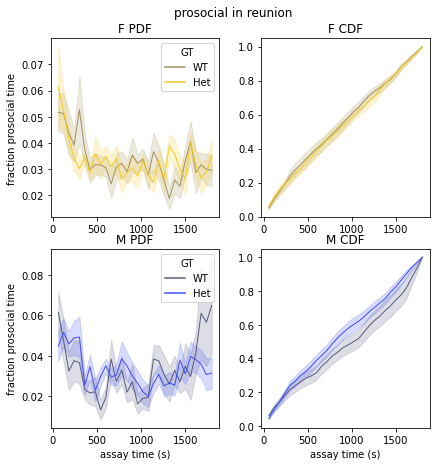

In [15]:
# ----- REUNION PROSOCIAL -----
prosoc = ['Huddle','Sniff','Investigate']
assay = 'reunion'
bsize = 60
sexes = ['F','M']

behavior = 'prosocial'

ncols = 2
nrows = len(sexes)

behaviorIdx = data.behavior.isin(prosoc)
trim = data[np.logical_and(behaviorIdx,data.assay==assay)]

f, ax = plt.subplots(nrows,ncols,figsize=(3*ncols, 3*nrows))
f.tight_layout()
f.suptitle(f'{behavior} in {assay}', y=1.04)

binned = bin_and_cume(trim,1800,bsize)
binned['binned_fracs'] = binned.data/binned.totals

for i,sx in enumerate(sexes):
    
    if sx == 'F':
        upal = fpal
    else:
        upal = mpal
    
    # plot PDF
    g = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,1],
    )
    
    # plot CDF
    h = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="binned_fracs", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,0],
    )
    
    ax[1,i].set_xlabel('assay time (s)')
    ax[0,i].set_xlabel('')
    ax[i,0].set_title(f'{sx} PDF')
    ax[i,1].set_title(f'{sx} CDF')
    g.get_legend().remove()
    sns.despine(ax=ax[0,0],top=True,right=True)
    sns.despine(ax=ax[0,1],top=True,right=True)
    sns.despine(ax=ax[1,0],top=True,right=True)
    sns.despine(ax=ax[1,1],top=True,right=True)

    
    if i>0:
        ax[0,i].set_ylabel('')
        ax[1,i].set_ylabel('')
#         h.get_legend().remove()
    else:
        ax[0,i].set_ylabel(f'fraction {behavior} time')
        ax[1,i].set_ylabel(f'fraction {behavior} time')

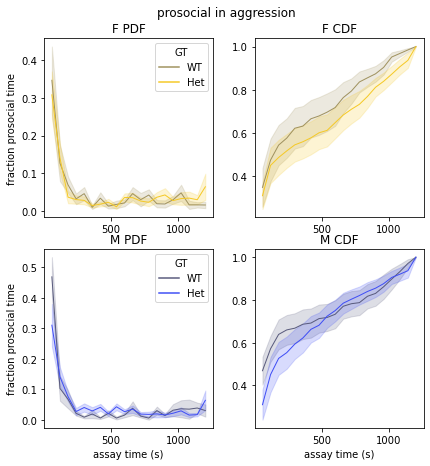

In [21]:
# ----- AGGRESSION PROSOCIAL -----
prosoc = ['Huddle','Sniff','Investigate']
assay = 'aggression'
bsize = 60
sexes = ['F','M']

behavior = 'prosocial'

ncols = 2
nrows = len(sexes)

behaviorIdx = data.behavior.isin(prosoc)
trim = data[np.logical_and(behaviorIdx,data.assay==assay)]

f, ax = plt.subplots(nrows,ncols,figsize=(3*ncols, 3*nrows))
f.tight_layout()
f.suptitle(f'{behavior} in {assay}', y=1.04)

binned = bin_and_cume(trim,1200,bsize)
binned['binned_fracs'] = binned.data/binned.totals

for i,sx in enumerate(sexes):
    
    if sx == 'F':
        upal = fpal
    else:
        upal = mpal
    
    # plot PDF
    g = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,1],
    )
    
    # plot CDF
    h = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="binned_fracs", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,0],
    )
    
    ax[1,i].set_xlabel('assay time (s)')
    ax[0,i].set_xlabel('')
    ax[i,0].set_title(f'{sx} PDF')
    ax[i,1].set_title(f'{sx} CDF')
    g.get_legend().remove()
    sns.despine(ax=ax[0,0],top=True,right=True)
    sns.despine(ax=ax[0,1],top=True,right=True)
    sns.despine(ax=ax[1,0],top=True,right=True)
    sns.despine(ax=ax[1,1],top=True,right=True)

    
    if i>0:
        ax[0,i].set_ylabel('')
        ax[1,i].set_ylabel('')
#         h.get_legend().remove()
    else:
        ax[0,i].set_ylabel(f'fraction {behavior} time')
        ax[1,i].set_ylabel(f'fraction {behavior} time')

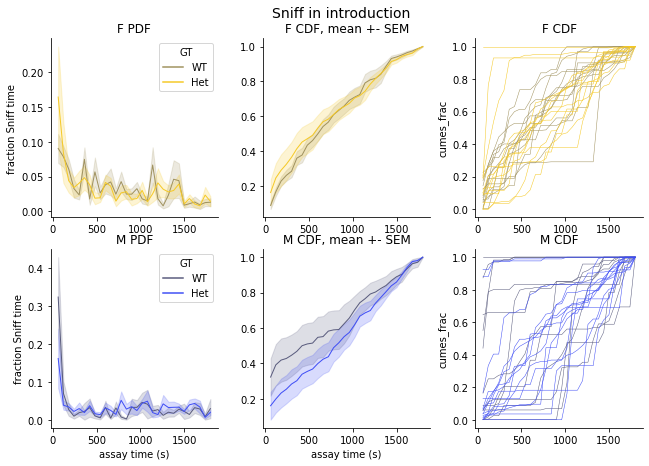

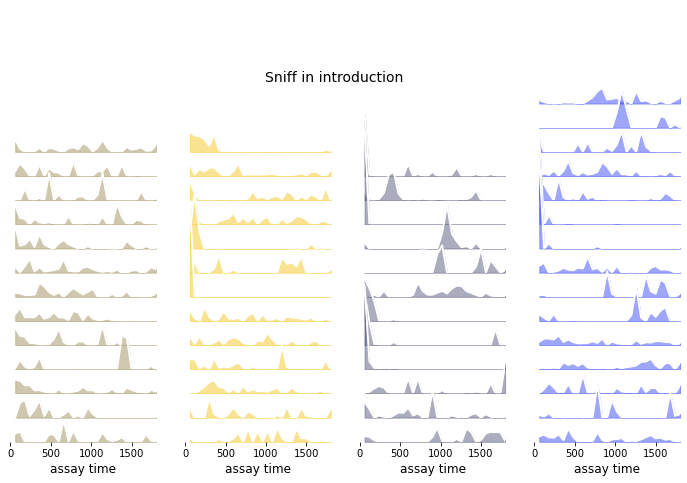

In [12]:
# ----- INTRODUCTION SNIFF -----
assay = 'introduction'
behavior = 'Sniff'
bsize = 60
nrows = 2
ncols = 3
sexes = ['F','M']
printy=True

trim = data[np.logical_and(data.behavior==behavior,data.assay==assay)]

f, ax = plt.subplots(nrows,ncols,figsize=(3*ncols, 3*nrows))
f.tight_layout()
f.suptitle(f'{behavior} in {assay}', y=1.04,fontsize=14)

binned = bin_and_cume(trim,1800,bsize)
binned['binned_fracs'] = binned.data/binned.totals

for i,sx in enumerate(sexes):
    
    if sx == 'F':
        upal = fpal
    else:
        upal = mpal
    
    # plot PDF
    g = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,1],
    )
    
    # plot group CDF
    h = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="binned_fracs", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,0],
    )
    
    # plot individual CDFs
    j = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",units='pair_tag',
        estimator=None,lw=0.5,palette=upal,hue_order=ho,
        ax = ax[i,2],
    )
    
    ax[1,i].set_xlabel('assay time (s)')
    ax[0,i].set_xlabel('')
    ax[i,0].set_title(f'{sx} PDF')
    ax[i,1].set_title(f'{sx} CDF, mean +- SEM')
    ax[i,2].set_title(f'{sx} CDF')
    ax[i,2].set_xlabel('')
    sns.despine(ax=ax[0,0],top=True,right=True)
    sns.despine(ax=ax[0,1],top=True,right=True)
    sns.despine(ax=ax[1,0],top=True,right=True)
    sns.despine(ax=ax[1,1],top=True,right=True)
    sns.despine(ax=ax[0,2],top=True,right=True)
    sns.despine(ax=ax[1,2],top=True,right=True)
    g.get_legend().remove()
    j.get_legend().remove()

    
    if i>0:
        ax[0,i].set_ylabel('')
        ax[1,i].set_ylabel('')
    else:
        ax[0,i].set_ylabel(f'fraction {behavior} time')
        ax[1,i].set_ylabel(f'fraction {behavior} time')
        
f2 = plot_PDF_ridge_plots_quad(binned,assay,behavior,acols)
        
# save figures
gfig = f'{assay}_{behavior}_group_CDF_PDF.png'
ifig = f'{assay}_{behavior}_individual_PDF.png'

if printy:
    f.savefig(os.path.join(outp,gfig))
    f2.savefig(os.path.join(outp,ifig))

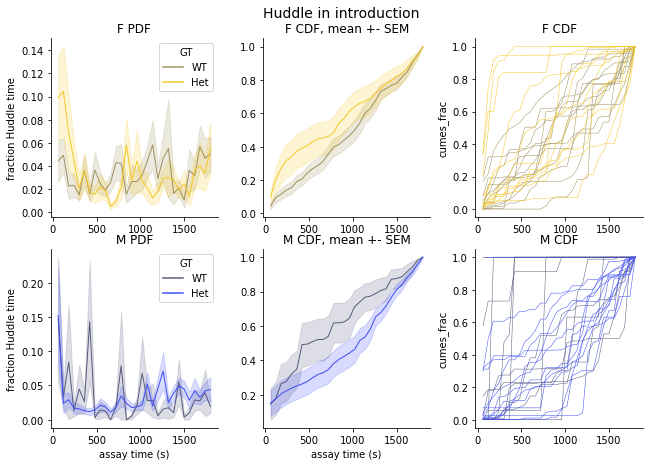

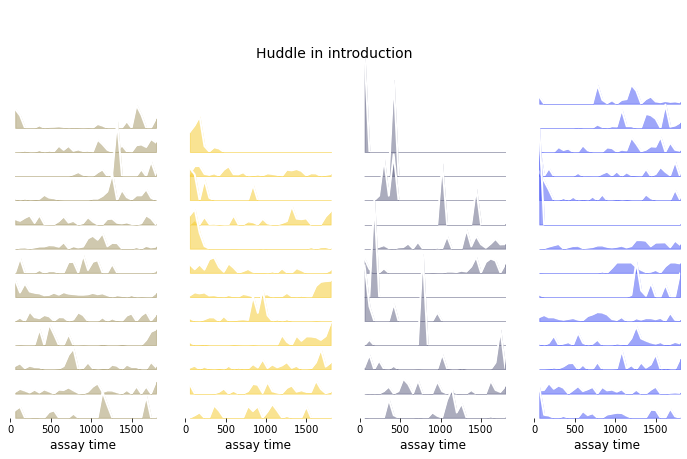

In [13]:
# ----- INTRODUCTION SNIFF -----
assay = 'introduction'
behavior = 'Huddle'
bsize = 60
nrows = 2
ncols = 3
sexes = ['F','M']
printy=True

trim = data[np.logical_and(data.behavior==behavior,data.assay==assay)]

f, ax = plt.subplots(nrows,ncols,figsize=(3*ncols, 3*nrows))
f.tight_layout()
f.suptitle(f'{behavior} in {assay}', y=1.04,fontsize=14)

binned = bin_and_cume(trim,1800,bsize)
binned['binned_fracs'] = binned.data/binned.totals

for i,sx in enumerate(sexes):
    
    if sx == 'F':
        upal = fpal
    else:
        upal = mpal
    
    # plot PDF
    g = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,1],
    )
    
    # plot group CDF
    h = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="binned_fracs", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,0],
    )
    
    # plot individual CDFs
    j = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",units='pair_tag',
        estimator=None,lw=0.5,palette=upal,hue_order=ho,
        ax = ax[i,2],
    )
    
    ax[1,i].set_xlabel('assay time (s)')
    ax[0,i].set_xlabel('')
    ax[i,0].set_title(f'{sx} PDF')
    ax[i,1].set_title(f'{sx} CDF, mean +- SEM')
    ax[i,2].set_title(f'{sx} CDF')
    ax[i,2].set_xlabel('')
    sns.despine(ax=ax[0,0],top=True,right=True)
    sns.despine(ax=ax[0,1],top=True,right=True)
    sns.despine(ax=ax[1,0],top=True,right=True)
    sns.despine(ax=ax[1,1],top=True,right=True)
    sns.despine(ax=ax[0,2],top=True,right=True)
    sns.despine(ax=ax[1,2],top=True,right=True)
    g.get_legend().remove()
    j.get_legend().remove()

    
    if i>0:
        ax[0,i].set_ylabel('')
        ax[1,i].set_ylabel('')
    else:
        ax[0,i].set_ylabel(f'fraction {behavior} time')
        ax[1,i].set_ylabel(f'fraction {behavior} time')
        
f2 = plot_PDF_ridge_plots_quad(binned,assay,behavior,acols)
        
# save figures
gfig = f'{assay}_{behavior}_group_CDF_PDF.png'
ifig = f'{assay}_{behavior}_individual_PDF.png'

if printy:
    f.savefig(os.path.join(outp,gfig))
    f2.savefig(os.path.join(outp,ifig))

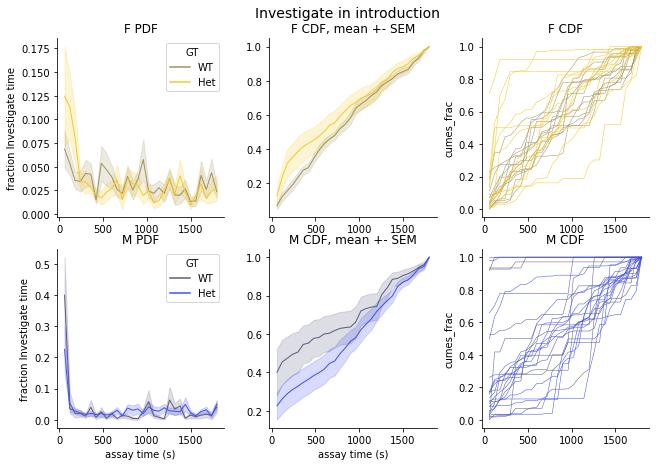

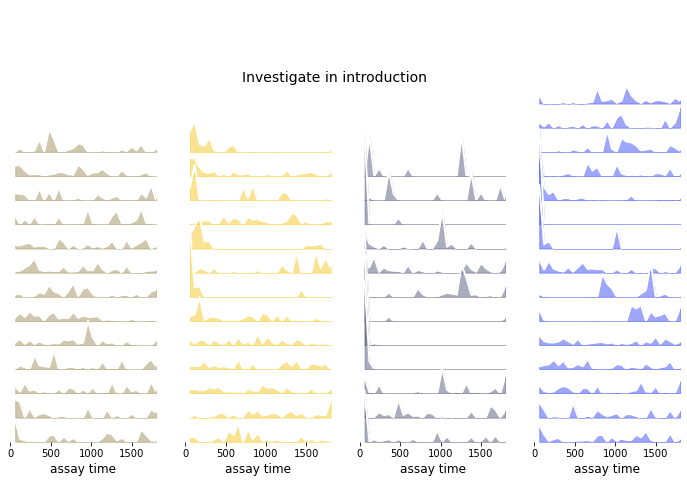

In [14]:
# ----- INTRODUCTION INVESTIGATE -----
assay = 'introduction'
behavior = 'Investigate'
bsize = 60
nrows = 2
ncols = 3
sexes = ['F','M']
printy=True

trim = data[np.logical_and(data.behavior==behavior,data.assay==assay)]

f, ax = plt.subplots(nrows,ncols,figsize=(3*ncols, 3*nrows))
f.tight_layout()
f.suptitle(f'{behavior} in {assay}', y=1.04,fontsize=14)

binned = bin_and_cume(trim,1800,bsize)
binned['binned_fracs'] = binned.data/binned.totals

for i,sx in enumerate(sexes):
    
    if sx == 'F':
        upal = fpal
    else:
        upal = mpal
    
    # plot PDF
    g = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,1],
    )
    
    # plot group CDF
    h = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="binned_fracs", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,0],
    )
    
    # plot individual CDFs
    j = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",units='pair_tag',
        estimator=None,lw=0.5,palette=upal,hue_order=ho,
        ax = ax[i,2],
    )
    
    ax[1,i].set_xlabel('assay time (s)')
    ax[0,i].set_xlabel('')
    ax[i,0].set_title(f'{sx} PDF')
    ax[i,1].set_title(f'{sx} CDF, mean +- SEM')
    ax[i,2].set_title(f'{sx} CDF')
    ax[i,2].set_xlabel('')
    sns.despine(ax=ax[0,0],top=True,right=True)
    sns.despine(ax=ax[0,1],top=True,right=True)
    sns.despine(ax=ax[1,0],top=True,right=True)
    sns.despine(ax=ax[1,1],top=True,right=True)
    sns.despine(ax=ax[0,2],top=True,right=True)
    sns.despine(ax=ax[1,2],top=True,right=True)
    g.get_legend().remove()
    j.get_legend().remove()

    
    if i>0:
        ax[0,i].set_ylabel('')
        ax[1,i].set_ylabel('')
    else:
        ax[0,i].set_ylabel(f'fraction {behavior} time')
        ax[1,i].set_ylabel(f'fraction {behavior} time')
        
f2 = plot_PDF_ridge_plots_quad(binned,assay,behavior,acols)
        
# save figures
gfig = f'{assay}_{behavior}_group_CDF_PDF.png'
ifig = f'{assay}_{behavior}_individual_PDF.png'

if printy:
    f.savefig(os.path.join(outp,gfig))
    f2.savefig(os.path.join(outp,ifig))

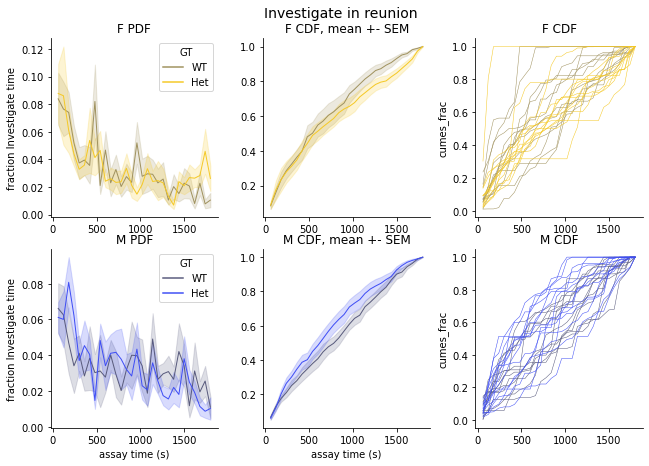

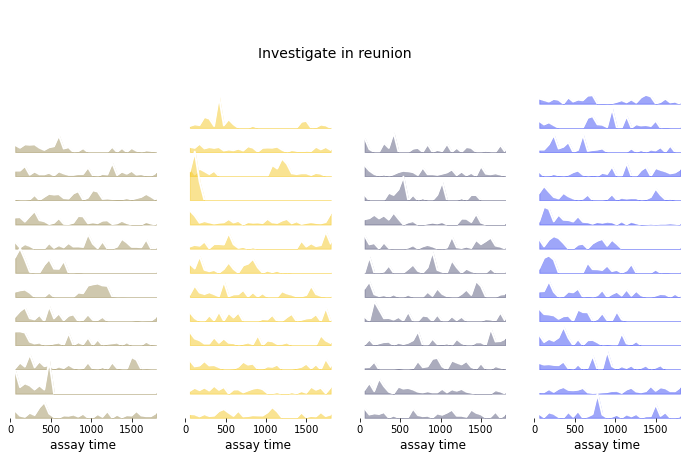

In [15]:
# ----- REUNION INVESTIGATE -----
assay = 'reunion'
behavior = 'Investigate'
bsize = 60
nrows = 2
ncols = 3
sexes = ['F','M']
printy=True

trim = data[np.logical_and(data.behavior==behavior,data.assay==assay)]

f, ax = plt.subplots(nrows,ncols,figsize=(3*ncols, 3*nrows))
f.tight_layout()
f.suptitle(f'{behavior} in {assay}', y=1.04,fontsize=14)

binned = bin_and_cume(trim,1800,bsize)
binned['binned_fracs'] = binned.data/binned.totals

for i,sx in enumerate(sexes):
    
    if sx == 'F':
        upal = fpal
    else:
        upal = mpal
    
    # plot PDF
    g = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,1],
    )
    
    # plot group CDF
    h = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="binned_fracs", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,0],
    )
    
    # plot individual CDFs
    j = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",units='pair_tag',
        estimator=None,lw=0.5,palette=upal,hue_order=ho,
        ax = ax[i,2],
    )
    
    ax[1,i].set_xlabel('assay time (s)')
    ax[0,i].set_xlabel('')
    ax[i,0].set_title(f'{sx} PDF')
    ax[i,1].set_title(f'{sx} CDF, mean +- SEM')
    ax[i,2].set_title(f'{sx} CDF')
    ax[i,2].set_xlabel('')
    sns.despine(ax=ax[0,0],top=True,right=True)
    sns.despine(ax=ax[0,1],top=True,right=True)
    sns.despine(ax=ax[1,0],top=True,right=True)
    sns.despine(ax=ax[1,1],top=True,right=True)
    sns.despine(ax=ax[0,2],top=True,right=True)
    sns.despine(ax=ax[1,2],top=True,right=True)
    g.get_legend().remove()
    j.get_legend().remove()

    
    if i>0:
        ax[0,i].set_ylabel('')
        ax[1,i].set_ylabel('')
    else:
        ax[0,i].set_ylabel(f'fraction {behavior} time')
        ax[1,i].set_ylabel(f'fraction {behavior} time')
        
f2 = plot_PDF_ridge_plots_quad(binned,assay,behavior,acols)
        
# save figures
gfig = f'{assay}_{behavior}_group_CDF_PDF.png'
ifig = f'{assay}_{behavior}_individual_PDF.png'

if printy:
    f.savefig(os.path.join(outp,gfig))
    f2.savefig(os.path.join(outp,ifig))

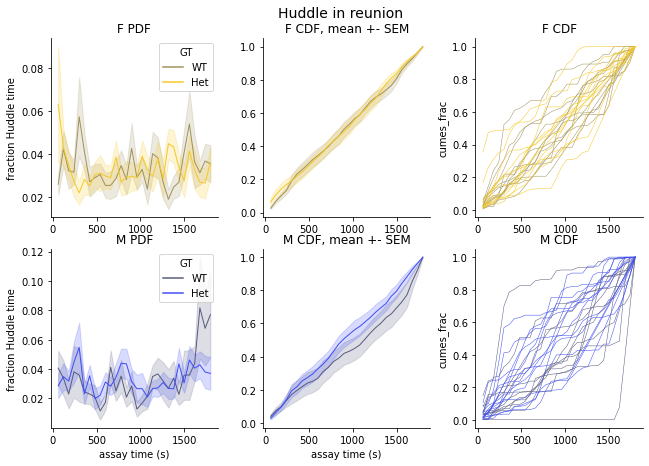

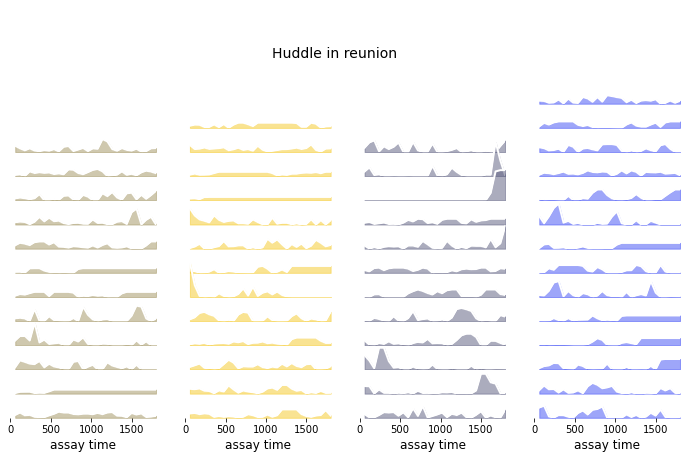

In [16]:
# ----- REUNION HUDDLE -----
assay = 'reunion'
behavior = 'Huddle'
bsize = 60
nrows = 2
ncols = 3
sexes = ['F','M']
printy=True

trim = data[np.logical_and(data.behavior==behavior,data.assay==assay)]

f, ax = plt.subplots(nrows,ncols,figsize=(3*ncols, 3*nrows))
f.tight_layout()
f.suptitle(f'{behavior} in {assay}', y=1.04,fontsize=14)

binned = bin_and_cume(trim,1800,bsize)
binned['binned_fracs'] = binned.data/binned.totals

for i,sx in enumerate(sexes):
    
    if sx == 'F':
        upal = fpal
    else:
        upal = mpal
    
    # plot PDF
    g = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,1],
    )
    
    # plot group CDF
    h = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="binned_fracs", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,0],
    )
    
    # plot individual CDFs
    j = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",units='pair_tag',
        estimator=None,lw=0.5,palette=upal,hue_order=ho,
        ax = ax[i,2],
    )
    
    ax[1,i].set_xlabel('assay time (s)')
    ax[0,i].set_xlabel('')
    ax[i,0].set_title(f'{sx} PDF')
    ax[i,1].set_title(f'{sx} CDF, mean +- SEM')
    ax[i,2].set_title(f'{sx} CDF')
    ax[i,2].set_xlabel('')
    sns.despine(ax=ax[0,0],top=True,right=True)
    sns.despine(ax=ax[0,1],top=True,right=True)
    sns.despine(ax=ax[1,0],top=True,right=True)
    sns.despine(ax=ax[1,1],top=True,right=True)
    sns.despine(ax=ax[0,2],top=True,right=True)
    sns.despine(ax=ax[1,2],top=True,right=True)
    g.get_legend().remove()
    j.get_legend().remove()

    
    if i>0:
        ax[0,i].set_ylabel('')
        ax[1,i].set_ylabel('')
    else:
        ax[0,i].set_ylabel(f'fraction {behavior} time')
        ax[1,i].set_ylabel(f'fraction {behavior} time')
        
f2 = plot_PDF_ridge_plots_quad(binned,assay,behavior,acols)
        
# save figures
gfig = f'{assay}_{behavior}_group_CDF_PDF.png'
ifig = f'{assay}_{behavior}_individual_PDF.png'

if printy:
    f.savefig(os.path.join(outp,gfig))
    f2.savefig(os.path.join(outp,ifig))

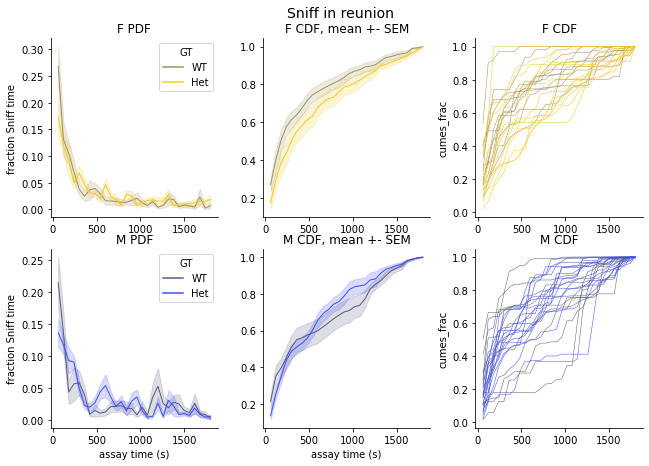

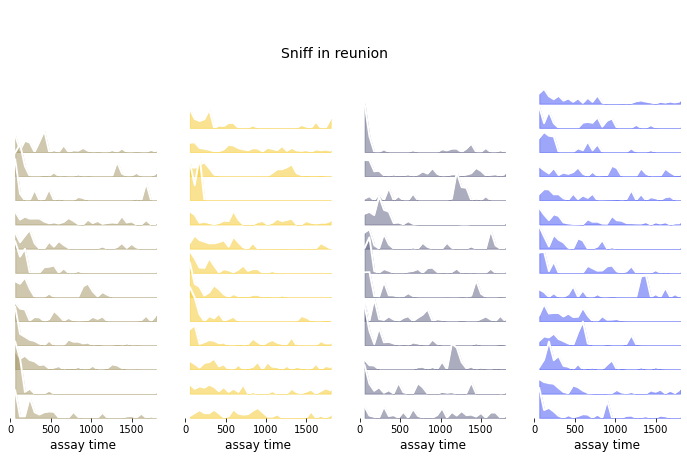

In [17]:
# ----- REUNION SNIFF -----
assay = 'reunion'
behavior = 'Sniff'
bsize = 60
nrows = 2
ncols = 3
sexes = ['F','M']
printy=True

trim = data[np.logical_and(data.behavior==behavior,data.assay==assay)]

f, ax = plt.subplots(nrows,ncols,figsize=(3*ncols, 3*nrows))
f.tight_layout()
f.suptitle(f'{behavior} in {assay}', y=1.04,fontsize=14)

binned = bin_and_cume(trim,1800,bsize)
binned['binned_fracs'] = binned.data/binned.totals

for i,sx in enumerate(sexes):
    
    if sx == 'F':
        upal = fpal
    else:
        upal = mpal
    
    # plot PDF
    g = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,1],
    )
    
    # plot group CDF
    h = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="binned_fracs", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,0],
    )
    
    # plot individual CDFs
    j = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",units='pair_tag',
        estimator=None,lw=0.5,palette=upal,hue_order=ho,
        ax = ax[i,2],
    )
    
    ax[1,i].set_xlabel('assay time (s)')
    ax[0,i].set_xlabel('')
    ax[i,0].set_title(f'{sx} PDF')
    ax[i,1].set_title(f'{sx} CDF, mean +- SEM')
    ax[i,2].set_title(f'{sx} CDF')
    ax[i,2].set_xlabel('')
    sns.despine(ax=ax[0,0],top=True,right=True)
    sns.despine(ax=ax[0,1],top=True,right=True)
    sns.despine(ax=ax[1,0],top=True,right=True)
    sns.despine(ax=ax[1,1],top=True,right=True)
    sns.despine(ax=ax[0,2],top=True,right=True)
    sns.despine(ax=ax[1,2],top=True,right=True)
    g.get_legend().remove()
    j.get_legend().remove()

    
    if i>0:
        ax[0,i].set_ylabel('')
        ax[1,i].set_ylabel('')
    else:
        ax[0,i].set_ylabel(f'fraction {behavior} time')
        ax[1,i].set_ylabel(f'fraction {behavior} time')
        
f2 = plot_PDF_ridge_plots_quad(binned,assay,behavior,acols)
        
# save figures
gfig = f'{assay}_{behavior}_group_CDF_PDF.png'
ifig = f'{assay}_{behavior}_individual_PDF.png'

if printy:
    f.savefig(os.path.join(outp,gfig))
    f2.savefig(os.path.join(outp,ifig))

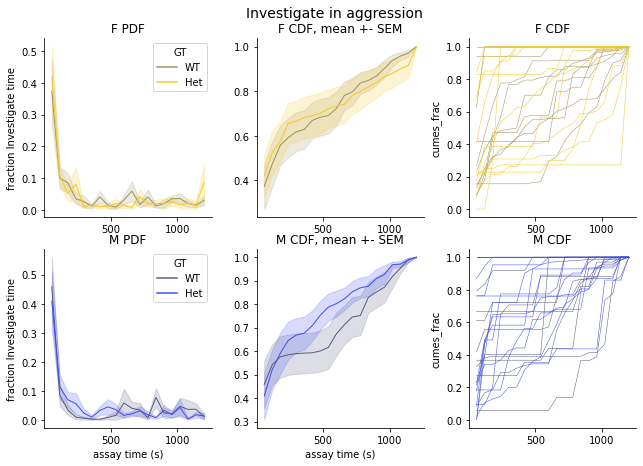

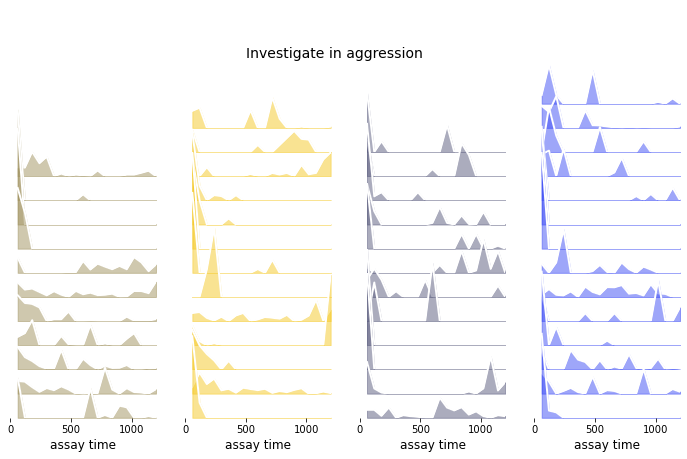

In [22]:
# ----- AGGRESSION INVESTIGATE -----
assay = 'aggression'
assaylen = 1200
behavior = 'Investigate'
bsize = 60
nrows = 2
ncols = 3
sexes = ['F','M']
printy=True

trim = data[np.logical_and(data.behavior==behavior,data.assay==assay)]

f, ax = plt.subplots(nrows,ncols,figsize=(3*ncols, 3*nrows))
f.tight_layout()
f.suptitle(f'{behavior} in {assay}', y=1.04,fontsize=14)

binned = bin_and_cume(trim,assaylen,bsize)
binned['binned_fracs'] = binned.data/binned.totals

for i,sx in enumerate(sexes):
    
    if sx == 'F':
        upal = fpal
    else:
        upal = mpal
    
    # plot PDF
    g = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,1],
    )
    
    # plot group CDF
    h = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="binned_fracs", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,0],
    )
    
    # plot individual CDFs
    j = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",units='pair_tag',
        estimator=None,lw=0.5,palette=upal,hue_order=ho,
        ax = ax[i,2],
    )
    
    ax[1,i].set_xlabel('assay time (s)')
    ax[0,i].set_xlabel('')
    ax[i,0].set_title(f'{sx} PDF')
    ax[i,1].set_title(f'{sx} CDF, mean +- SEM')
    ax[i,2].set_title(f'{sx} CDF')
    ax[i,2].set_xlabel('')
    sns.despine(ax=ax[0,0],top=True,right=True)
    sns.despine(ax=ax[0,1],top=True,right=True)
    sns.despine(ax=ax[1,0],top=True,right=True)
    sns.despine(ax=ax[1,1],top=True,right=True)
    sns.despine(ax=ax[0,2],top=True,right=True)
    sns.despine(ax=ax[1,2],top=True,right=True)
    g.get_legend().remove()
    j.get_legend().remove()

    
    if i>0:
        ax[0,i].set_ylabel('')
        ax[1,i].set_ylabel('')
    else:
        ax[0,i].set_ylabel(f'fraction {behavior} time')
        ax[1,i].set_ylabel(f'fraction {behavior} time')
        
f2 = plot_PDF_ridge_plots_quad(binned,assay,behavior,acols,assaylen)
        
# save figures
gfig = f'{assay}_{behavior}_group_CDF_PDF.png'
ifig = f'{assay}_{behavior}_individual_PDF.png'

if printy:
    f.savefig(os.path.join(outp,gfig))
    f2.savefig(os.path.join(outp,ifig))

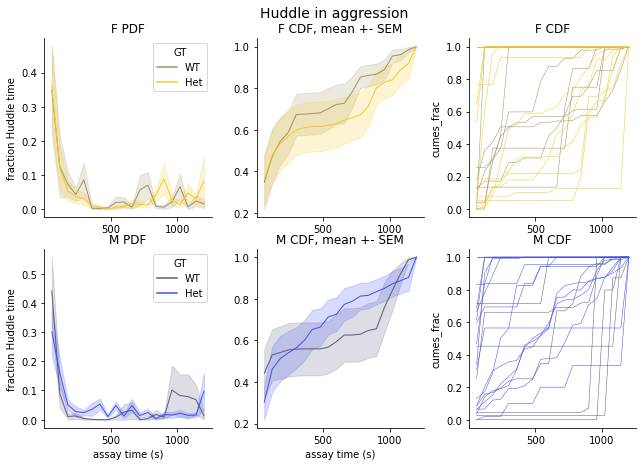

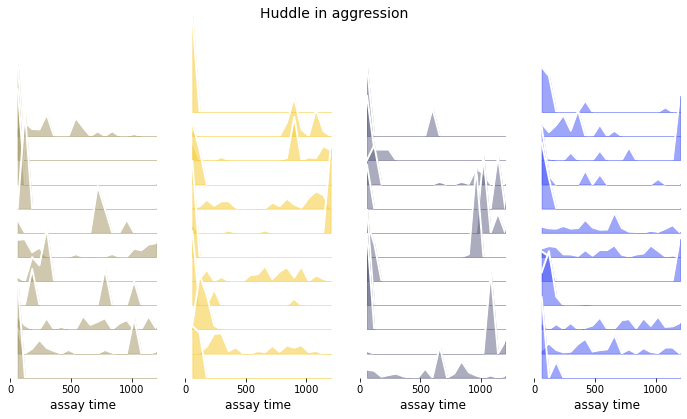

In [23]:
# ----- AGGRESSION HUDDLE -----
assay = 'aggression'
assaylen = 1200
behavior = 'Huddle'
bsize = 60
nrows = 2
ncols = 3
sexes = ['F','M']
printy=True

trim = data[np.logical_and(data.behavior==behavior,data.assay==assay)]

f, ax = plt.subplots(nrows,ncols,figsize=(3*ncols, 3*nrows))
f.tight_layout()
f.suptitle(f'{behavior} in {assay}', y=1.04,fontsize=14)

binned = bin_and_cume(trim,assaylen,bsize)
binned['binned_fracs'] = binned.data/binned.totals

for i,sx in enumerate(sexes):
    
    if sx == 'F':
        upal = fpal
    else:
        upal = mpal
    
    # plot PDF
    g = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,1],
    )
    
    # plot group CDF
    h = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="binned_fracs", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,0],
    )
    
    # plot individual CDFs
    j = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",units='pair_tag',
        estimator=None,lw=0.5,palette=upal,hue_order=ho,
        ax = ax[i,2],
    )
    
    ax[1,i].set_xlabel('assay time (s)')
    ax[0,i].set_xlabel('')
    ax[i,0].set_title(f'{sx} PDF')
    ax[i,1].set_title(f'{sx} CDF, mean +- SEM')
    ax[i,2].set_title(f'{sx} CDF')
    ax[i,2].set_xlabel('')
    sns.despine(ax=ax[0,0],top=True,right=True)
    sns.despine(ax=ax[0,1],top=True,right=True)
    sns.despine(ax=ax[1,0],top=True,right=True)
    sns.despine(ax=ax[1,1],top=True,right=True)
    sns.despine(ax=ax[0,2],top=True,right=True)
    sns.despine(ax=ax[1,2],top=True,right=True)
    g.get_legend().remove()
    j.get_legend().remove()

    
    if i>0:
        ax[0,i].set_ylabel('')
        ax[1,i].set_ylabel('')
    else:
        ax[0,i].set_ylabel(f'fraction {behavior} time')
        ax[1,i].set_ylabel(f'fraction {behavior} time')
        
f2 = plot_PDF_ridge_plots_quad(binned,assay,behavior,acols,assaylen)
        
# save figures
gfig = f'{assay}_{behavior}_group_CDF_PDF.png'
ifig = f'{assay}_{behavior}_individual_PDF.png'

if printy:
    f.savefig(os.path.join(outp,gfig))
    f2.savefig(os.path.join(outp,ifig))

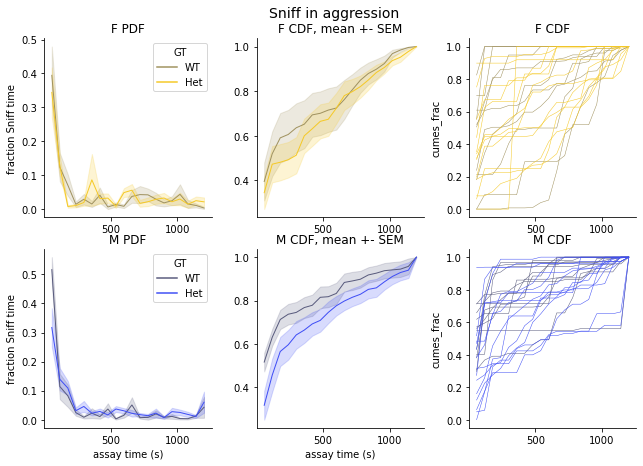

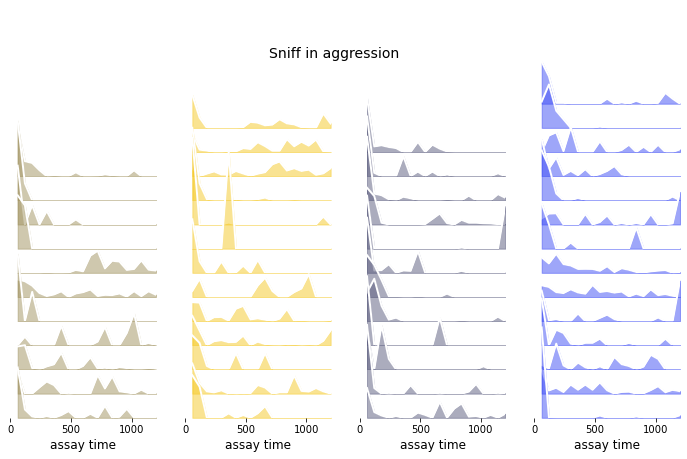

In [24]:
# ----- AGGRESSION SNIFF -----
assay = 'aggression'
assaylen = 1200
behavior = 'Sniff'
bsize = 60
nrows = 2
ncols = 3
sexes = ['F','M']
printy=True

trim = data[np.logical_and(data.behavior==behavior,data.assay==assay)]

f, ax = plt.subplots(nrows,ncols,figsize=(3*ncols, 3*nrows))
f.tight_layout()
f.suptitle(f'{behavior} in {assay}', y=1.04,fontsize=14)

binned = bin_and_cume(trim,assaylen,bsize)
binned['binned_fracs'] = binned.data/binned.totals

for i,sx in enumerate(sexes):
    
    if sx == 'F':
        upal = fpal
    else:
        upal = mpal
    
    # plot PDF
    g = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,1],
    )
    
    # plot group CDF
    h = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="binned_fracs", hue="GT",
        estimator='mean', errorbar='se',lw=1,palette=upal,hue_order=ho,
        ax = ax[i,0],
    )
    
    # plot individual CDFs
    j = sns.lineplot(
        data=binned[binned.sex==sx],
        x="bins", y="cumes_frac", hue="GT",units='pair_tag',
        estimator=None,lw=0.5,palette=upal,hue_order=ho,
        ax = ax[i,2],
    )
    
    ax[1,i].set_xlabel('assay time (s)')
    ax[0,i].set_xlabel('')
    ax[i,0].set_title(f'{sx} PDF')
    ax[i,1].set_title(f'{sx} CDF, mean +- SEM')
    ax[i,2].set_title(f'{sx} CDF')
    ax[i,2].set_xlabel('')
    sns.despine(ax=ax[0,0],top=True,right=True)
    sns.despine(ax=ax[0,1],top=True,right=True)
    sns.despine(ax=ax[1,0],top=True,right=True)
    sns.despine(ax=ax[1,1],top=True,right=True)
    sns.despine(ax=ax[0,2],top=True,right=True)
    sns.despine(ax=ax[1,2],top=True,right=True)
    g.get_legend().remove()
    j.get_legend().remove()

    
    if i>0:
        ax[0,i].set_ylabel('')
        ax[1,i].set_ylabel('')
    else:
        ax[0,i].set_ylabel(f'fraction {behavior} time')
        ax[1,i].set_ylabel(f'fraction {behavior} time')
        
f2 = plot_PDF_ridge_plots_quad(binned,assay,behavior,acols,assaylen)
        
# save figures
gfig = f'{assay}_{behavior}_group_CDF_PDF.png'
ifig = f'{assay}_{behavior}_individual_PDF.png'

if printy:
    f.savefig(os.path.join(outp,gfig))
    f2.savefig(os.path.join(outp,ifig))

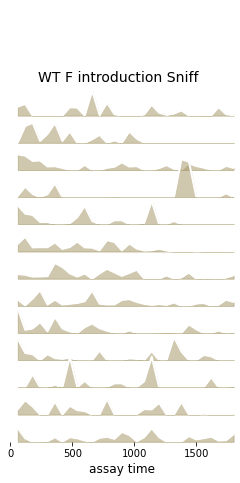

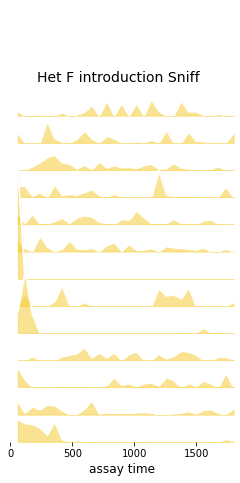

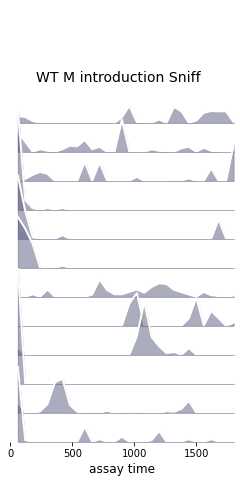

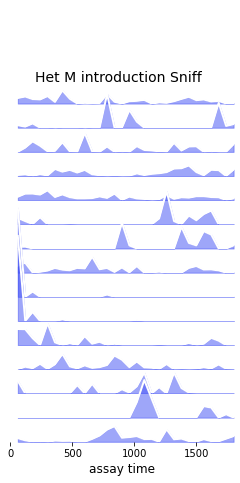

In [60]:
GTs = ['WT','Het']
colcount = 0
for sx in sexes:
    for usegt in GTs:
        usedf = binned[np.logical_and(binned.sex==sx,binned.GT==usegt)]
        thisfig = plot_PDF_ridge_plots(usedf,usegt,sx,assay,behavior,acols[colcount])
        figname = f'individual_PDF_{assay}_{behavior}_{sx}_{usegt}.jpg'
        thisfig.savefig(os.path.join(outp,figname))
        colcount+=1

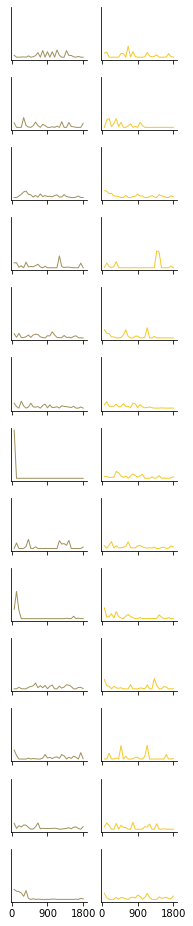

In [8]:
# ----- INDIVIDUAL LINES FOR PDFS -----
assay = 'introduction'
behavior = 'Sniff'
bsize = 60
sx = 'F'
assaylen = 1800

trim = data[np.logical_and(data.behavior==behavior,data.assay==assay)]
binned = bin_and_cume(trim,assaylen,bsize)
binned['binned_fracs'] = binned.data/binned.totals

sexfilt = binned[binned.sex==sx]

if sx == 'F':
    upal = fpal
else:
    upal = mpal
    
g = sns.relplot(
    data=sexfilt,
    x="bins", y="binned_fracs", row='pair_number',col="GT", hue="GT",
    kind="line", palette=upal, linewidth=1, # zorder=5,
    height=1, aspect=1.5, legend=False,
)

g.set_titles("")
g.set_axis_labels("")
g.tight_layout()

# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# g.figure.subplots_adjust(hspace=-.1)

# # Remove axes details that don't play well with overlap
# g.set_titles("")
g.set(yticks=[], ylabel="",xticks=[0,900,1800])
# g.despine(bottom=True, left=True)